## Cleaning

In [214]:
%%capture

%run './lib/libraries.ipynb'
from .lib import utilities as util
from pyspark.sql import functions as F

dython              0.6.1
tinydb              4.2.0


You should consider upgrading via the '/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/bin/python -m pip install --upgrade pip' command.


In [215]:
filterDf  = util.load_df('filterDf')
cleanDf = filterDf

### Remove unused variables

#### Remove unary learner_attempt_status = "fully scored"

In [216]:
cleanDf = cleanDf.drop('learner_attempt_status')

In [217]:
util.finish_todo('Remove unary learner_attempt_status = "fully scored"')

#### Remove attempt stop dates before start date

In [220]:
cleanDf = util.remove_stop_dates_before_start_dates(cleanDf)

In [221]:
util.finish_todo('Remove attempt stop dates before start date')

#### Remove 3298 null values in raw_score

In [222]:
cleanDf = cleanDf.filter( F.col('raw_score').isNull() == False )

In [223]:
util.finish_todo('Remove 3298 null values in raw_score')

#### Remove 1566 null dates

In [224]:
cleanDf = cleanDf.filter(
      ( F.col('assignment_due_date').isNull() == False )
    & ( F.col('assignment_final_submission_date').isNull() == False )
    & ( F.col('assignment_start_date').isNull() == False )
 )

In [225]:
util.finish_todo('Remove 1566 null dates')


### Impute

#### Remove 749 t0 750 student start or stop null dates
Impute null dates
   - in
      - student_start_datetime
      - student_stop_datetime
      - was_fully_scored_datetime

- Before

In [226]:
util.date_statisticts(cleanDf, ['student_start_datetime', 'student_stop_datetime' , 'was_fully_scored_datetime'])

,distinct,null,min,max
student_start_datetime,6778,427,2019-08-23,2020-05-26
student_stop_datetime,6600,427,2019-08-23,2020-05-26
was_fully_scored_datetime,6732,428,2019-08-23,2020-05-26


In [227]:
cleanDf = util.remove_null_student_dates(cleanDf)

# Delete any remaining nulls to make sure other varaibles are not imputed using these
cleanDf = cleanDf.filter( (F.col('student_start_datetime').isNull() == False ) & (F.col('student_stop_datetime').isNull() == False ) & (F.col('was_fully_scored_datetime').isNull() == False ) )

After

In [228]:
util.date_statisticts(cleanDf, ['student_start_datetime', 'student_stop_datetime' , 'was_fully_scored_datetime'])

,distinct,null,min,max
student_start_datetime,6812,0,2019-08-23,2020-05-26
student_stop_datetime,6634,0,2019-08-23,2020-05-26
was_fully_scored_datetime,6767,0,2019-08-23,2020-05-26


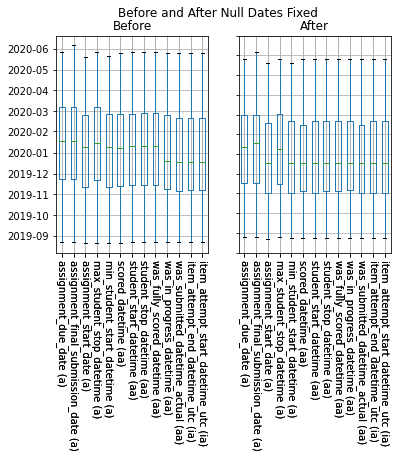

In [229]:
util.dual_date_boxplot(
    util.get_random_sample(filterDf),
    util.get_random_sample(cleanDf),
    title1='Before',
    title2='After',
    main='Before and After Null Dates Fixed'
)

- Median changes
  - assignment_start_date

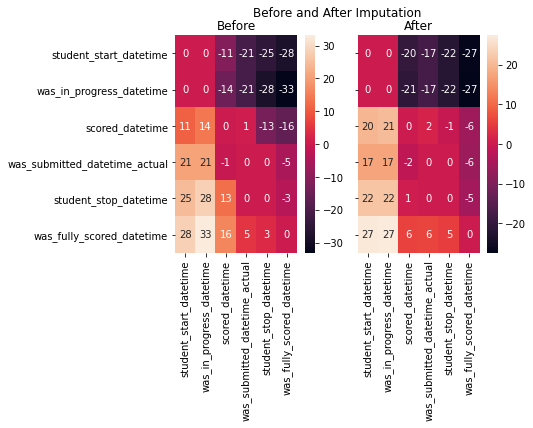

In [230]:
util.dual_mean_hours_assignment(
    util.get_random_sample(filterDf),
    util.get_random_sample(cleanDf),
    title1 = 'Before',
    title2 = 'After',
    main = 'Before and After Imputation'
)

Before and After Values Match
- student_start_datetime & scored_datetime = 9
- student_stop_datetime  & scored_datetime = -12
- was_fully_scored_datetime & scored_datetime = -17

In [231]:
util.finish_todo('Remove 749 t0 750 student start or stop null dates')

#### Reduce number of levels in item_type_code_name

###### Categories before

In [232]:
# Before Categories
cleanDf.select("item_type_code_name").distinct().orderBy("item_type_code_name").show(50, False)


+-------------------+
|item_type_code_name|
+-------------------+
|aheAlgo            |
|bucketing          |
|choiceMatrix       |
|cloze              |
|equationEntry      |
|essay              |
|fileUpload         |
|fillInTheBlank     |
|graphing           |
|imageLabel         |
|matching           |
|multipleChoice     |
|multipleSelect     |
|numberLine         |
|selectText         |
|shortAnswer        |
|sortable           |
|trueFalse          |
+-------------------+



In [233]:
cleanDf = util.reduce_type_code_levels(cleanDf)

###### Categories after

In [234]:
# Display new values
cleanDf.groupBy("item_type_code_name").count().orderBy("count", ascending=False).show(50, False)

+-------------------+-----+
|item_type_code_name|count|
+-------------------+-----+
|multipleChoice     |26686|
|Other              |13628|
|fillInTheBlank     |10494|
|equationEntry      |7841 |
|trueFalse          |4551 |
+-------------------+-----+



In [235]:
util.finish_todo('Reduce number of levels in item_type_code_name')


In [236]:
util.save_df(cleanDf, 'cleanDf')